#  A tour of Hammurabi's capabilities

First see the quick-start notebook on basic hammurabi and hampy usage.  See the viewer notebooks for how the viewers work.  Here, we will use all of that to discuss hammurabi itself.  

In [1]:
%matplotlib inline
import hampy
import healpy as hp
import numpy as np
from view_patch import view_patch
from view_field import view_field
import matplotlib
from pylab import cm
#  The color tables on different systems
#   which is annoying.  Set it explicitly:
cmap=cm.get_cmap('jet')
cmap.set_under('w')

Hammurabi was designed to do full-sky simulations of the Milky Way Galaxy, but it has been extended to several other contexts.  It can integrate a small patch of sky only and write a list of pixels with observables instead of a full HEALPix map.  It can use models computed analytically (and includes a number of these) but can also take as input an external binary file that contains the field sampled on a Cartesian grid.  This input can include the entire Galaxy, a region surrounding the observer, or only an isolated object.  If the latter, hammurabi can place the object at a given (lon,lat) and distance and integrate only the appropriate region of the sky.  

In the quick-start notebook, we have already seen how we run hammurabi.  The default behavior is to create full-sky maps integrated through the full Galaxy, and one can simply select the regular field model by number where:

  1:  ASS model from WMAP, Page et al. (2007)
  
  2:  Stanev BSS model (astro-ph/9607086)
  
  3:  Sun et al. ASS+Ring model (A&A, 477, 2008)
  
  4:  HRM model from Kachelriess et al. APh 2007 
  
  5:  TT model from Kalchelriess et al. ApH 2007 
  
  6:  External file, binary dump.  
  
  7:  Jansson & Farrar (2012, ApJ 757,14, and 2012, 761, L11)
  
  8:  Fauvet et al. (2011, A&A, 526, 145)
  
  10:  Jaffe et al. (2010, MNRAS, 401, 1013)
  
  We also saw there how to add a random component.  
  


#  Usage
As described in the original Waelkens et al. (2008) paper, hammurabi is designed to perform 3D integration by refining the grid successively with distance in order to preserve a roughly constant cell size as the distance increases.  It uses a set of nested shells, and in each shell, the resolution is a factor of 2 higher in HEALPix Nside  than the previous shell, which means each pixel is subdivided by 4 from one shell to the next.  

To configure this, use the total_shell_numb=N and obs_shell_num=M parameters.  N=3 and M=1, for example, means that the observables are computed at the lowest resolution shell by averaging emission in the higher resolution shells.  This is useful, for example, to simulate beam depolarization effects.  (One could use a single high-resolution and then apply a beam afterward, but this would waste time integrating the nearby space at too high a resolution.)  The boundaries between the shells are predetermined.  The furthest half of the LOS is the highest resolution shell, and the remaining nearer regions are successively divided in half.  See the image at:

https://a.fsdn.com/con/app/proj/hammurabicode/screenshots/Screen%20Shot%202016-06-03%20at%2014.36.30.png/1

which shows four shells, the highest at Nside=128.  

The LOS is then divided up into cells.  The total number of cells along the entire LOS is set by the vec_size_R parameter.  The image shows how the cells, with constant dR, have angular sizes that increases with distance, but because of the shells, remain within a factor of 2 in width.  

One should match the integration resolution with the resolution of the fields being integrated.  In the case of the random field, its resolution is determined by the dimensions of the grid.  To help compare, hammurabi prints a SanityCheck() in the log:

In [2]:
# The default parameters with the random component turned on:
ham=hampy.Hampy(custom_parameters={"B_field_do_random":"T"})
# Just print some of those, the one's we're interested in now:
ham.get_params(["obs_NSIDE","total_shell_numb","obs_shell_index_numb","vec_size_R","max_radius","B_field_nx"])

{'B_field_nx': 128,
 'max_radius': '30',
 'obs_NSIDE': '128',
 'obs_shell_index_numb': '3',
 'total_shell_numb': '3',
 'vec_size_R': '120'}

In [3]:
#  Call the hammurabi executable:
ham.call()

...

0

Just grab the relevant part of the log (it expects the start and stop line you want;  giving negatives means counting back from the end, and if only the start is given, then it's like the unix "tail" command):

In [4]:
ham.print_log(113,128)


----------------------
HAMMURABI Sanity Check:

DeltaR=0.25 kpc
At R_max (max Nside=128), DeltaX=0.239842 kpc
Random grid deltaX=0.3125 kpc
Random grid deltaY=0.3125 kpc
Random grid deltaZ=0.307692 kpc
Memory for grid:  10.2236 MB

HAMMURABI Sanity Check done
----------------------



This shows that the default parameters (set for speed, not for resolution!) divide the maximum LOS (30) into cells that are 250pc deep.  This applies to all shells.  But the width of the cells vary with distance.  In this case, at the maximum distance, the highest resolution shell is Nside=128, and what is printed is the physical width of the furthest possible cell, which in this case is 240pc, i.e., a little smaller than its depth.  (But that width cannot be tuned to better than a factor of 2.)   At the front of each shell, the width is halved.  But then the width is the same again at the back of the next shell inward, since the distance is halved but so is the Nside and therefore the angular width.  (Again, see the image linked above.)  

The log then shows for comparison the random grid that was defined, in this case with a cell size of 313pc (a 40kpc box divided into 128 bins).  It's not going to get more precisely matched, since the width of the cells increases with distance.   

It also warns that the z resolution is slightly different from the x,y resolution, which in this case is not important.  

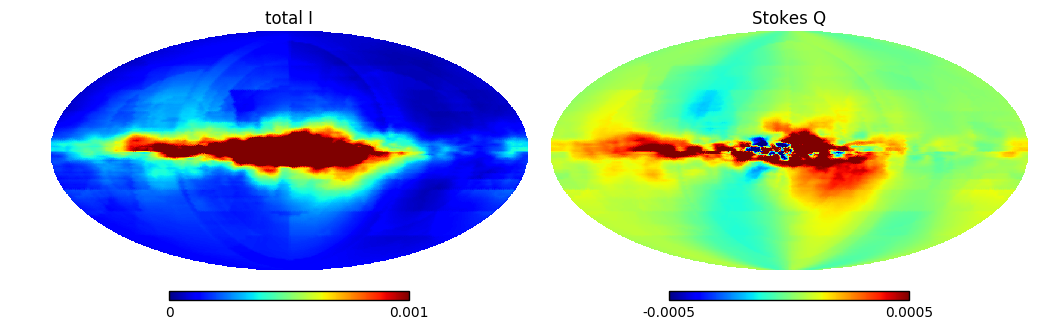

In [5]:
matplotlib.rcParams['figure.figsize'] = (10.0, 4.0)
maps=ham.get_observables()
hp.mollview(maps['Is'],min=0,max=0.001,sub=(1,2,1),title="total I",cmap=cmap)
hp.mollview(maps['Qs'],min=-5e-4,max=5e-4,sub=(1,2,2),title="Stokes Q",cmap=cmap)

Note that each random realization is based on a random number generator, which is given an intial seed.  The hammurabi executable has a "B_field_seed" parameter that is by default zero, which tells the code to generate a seed from the system clock.  But the hampy module by default sets this seed to a specific value so that re-running these tutorials will always produce identical results.  You can re-run the above by setting that seed to another non-zero integer to see how the realization changes.  I.e. 

In [6]:
ham.call(custom_parameters={"B_field_seed":2395345})

...

0

(When working in a batch to generate a set of realizations, you need to be careful how this seed is handled.  Leaving it by default set to zer means all the batch jobs will use the system clock.  If they start at the same time, they will be identical, which is not likely to be what you want.) 

#  Local modeling:
Now lets look at the field option 6, in which we give an external field.  By default, this would be centered on the Galactic center.  But in this example, we center it on the observer.  This field model has four shells whose angular diameters and locations approximate the four largest radio loops within a distance of 3 kpc.

In order to run this, you will need to download another data file, in this case the unit test file found at

https://sourceforge.net/projects/hammurabicode/files/supplementary/testing/hammurabi_unit_test_inputs.tgz/download

and untar it underneath the unit_test subdirectory of hammurabi.  

First, let's look at the field:

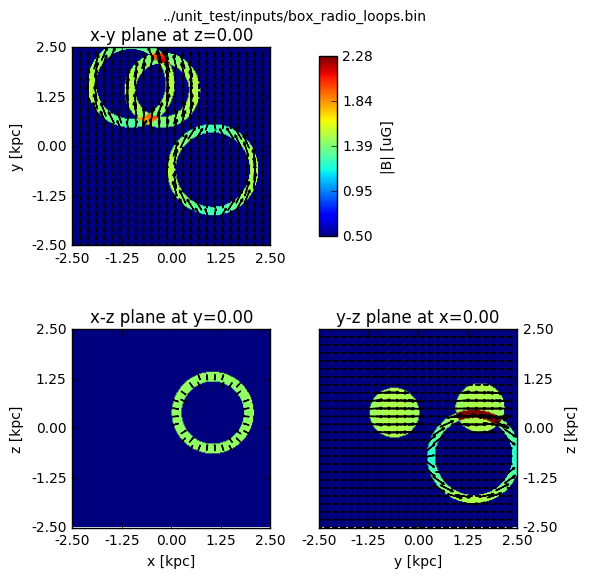

In [8]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
view_field(infile="../unit_test/inputs/box_radio_loops.bin",
           Ndims=[200,200,200],
           Ldims=[5,5,5],
           origin=[2.5,2.5,2.5],
           dtype="double",
           bscale=0.05,
           bskip=8
          )

And now integrate the full sky from an observer in the center of the above box and view the results:

In [9]:
ham=hampy.Hampy()
ham.call(custom_parameters={
            "B_field_do_random":"F",    # Turn off random
            "max_radius":"2.5",           # Integrate only 2.5kpc out
            "obs_freq_GHz":"1.4", 
            "TE_constant_pccm":"0.1",   # Constant TE
            "B_field_type":"6",         # External field file
            "B_field_coherent_inp":"../unit_test/inputs/box_radio_loops.bin",
            "B_field_ec":"T",           # Center the box on the observer ("earth centric")
            "B_field_inp_type":"double",# The data type of the box;  float is the new default, 
                                        #   but this file is older and written as doubles.
            "B_field_nx":"200",         # The number of cells in each direction
            "B_field_ny":"200",
            "B_field_nz":"200",
            "vec_size_R":"100",         # Adjusted to match box
            "B_field_lx":"5",           # The physical size in kpc
            "B_field_ly":"5",
            "B_field_lz":"5",
            "do_RM":"F"
    })


.......

0

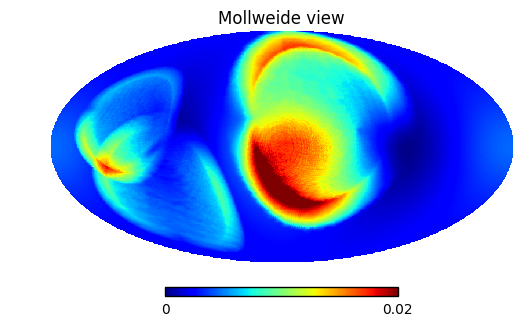

In [10]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
maps2=ham.get_observables()
hp.mollview(maps2['Is'],max=0.02,min=0,hold=True,cmap=cmap) 

# Individual objects:
In this example, we look at a more physical model, a SNR at a given distance in the Galaxy.  (This example is also used in the view_patch notebook, but here we show the details of the model and integration.)  And we integrate only in a given region, writing the result not to a HEALPix map but at a high resolution to a simple list of the relevant pixels.  

In [11]:
ham=hampy.Hampy(custom_parameters="test/params_SNR_quick.txt",working_directory="./test_SNR_quick.out")
ham.call()

...

0

In [12]:
ham.print_log(-32,-14)

----------------------
HAMMURABI Sanity Check:

DeltaR=0.000155 kpc
At R_max (max Nside=8192), DeltaX=0.000251709 kpc
Random grid deltaX=0.000164062 kpc
Random grid deltaY=0.000164062 kpc
Random grid deltaZ=0.000164062 kpc
Transform along longitude 180deg and latitude 14.6deg
Grid from longitude 179.702 to 180.298 deg
Pixel list from longitude 179.7 to 180.3 deg
Grid from latitude 14.3023 to 14.8977 deg
Pixel list from latitude 14.3 to 14.9 deg
Memory for grid:  50.3316 MB

HAMMURABI Sanity Check done
----------------------



The SanityCheck shows that the cells are about 0.15pc deep and at most 0.25pc wide.  The grid is defined also to have cells 0.164pc wide.  In this case of a patch of the sky, the SanityCheck also shows the longitude and latitude given as compared to the longitude and latitude of the box of the given size placed at the given distance.  This allows you to make sure you are observing the thole thing.  

Note that in this context, the HEALPix-based resolution shells are not likely to be of any use to you.  They are always defined relative to the full distance between the observer and the max_radius.  In this sort of example, the only integration is relatively near that maximum, so only one shell will actually be relevant.  

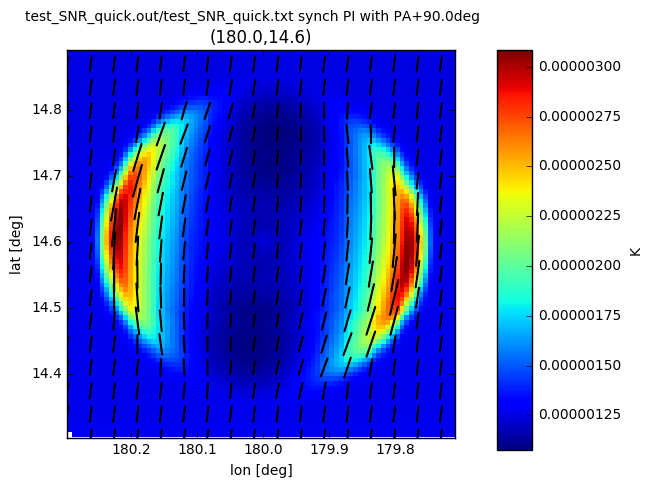

In [14]:
matplotlib.rcParams['figure.figsize'] = (7.0, 5.0)
data=view_patch(infile='test_SNR_quick.out/test_SNR_quick.txt',
           nside=8192,
           synch=True,
           polarization=4
          )

# Random field parameters
The GRF has only three real parameters.  The dimensions of the box determines the highest modes included.  (Note that the spectrum is smoothed with a Gaussian beam at the highest resolution to ensure that the result is appropriately sampled to avoid aliasing effects during the FFT.) You can change the spectral index.  And you can set the outer scale of turbulence, i.e., the length scale of the maximum wavemode.

Let's redo the previous SNR example, but we will add a random component with the default parameters.  (The default index is -0.37 (1D) and the cutoff-scale is 5kpc.  The latter is not physically motivated but only because the default is a low-resolution case that runs quickly.  The index -0.37 is the 1D index from Han, Ferriere, and Manchester study of pulsars.  The actual value in hammurabi is the 3D equivalent, i.e. -2.37.)  

In [15]:
ham.call(custom_parameters={"B_field_do_random":"T"})

.....

0

Let's see what the SanityCheck said about it:

In [23]:
ham.print_log(-43,-23)

----------------------
HAMMURABI Sanity Check:

DeltaR=0.000155 kpc
At R_max (max Nside=8192), DeltaX=0.000251709 kpc
Random grid deltaX=0.000164062 kpc
Random grid deltaY=0.000164062 kpc
Random grid deltaZ=0.000164062 kpc
Transform along longitude 180deg and latitude 14.6deg
Grid from longitude 179.702 to 180.298 deg
Pixel list from longitude 179.7 to 180.3 deg
Grid from latitude 14.3023 to 14.8977 deg
Pixel list from latitude 14.3 to 14.9 deg
Memory for grid:  50.3316 MB

HAMMURABI Sanity Check done
----------------------

DEBUGGING:  given the nx, lx, and cutoff you specified, you have:
DEBUGGING:     k_cutoff=10.5 and k0=42


Below the SanityCheck, it printed the wavenumbers for the outer (cutoff) scale and for the automatically computed smoothing that cuts off the smallest scales (k0).  As long as you have a lot of wavemodes between k_cutoff and k0, you are sampling lots of physical scales.  In the above case, the outer scale is the default of several kpc, which is much larger than the 20pc box, so the k_cutoff is much less than one and irrelevant.

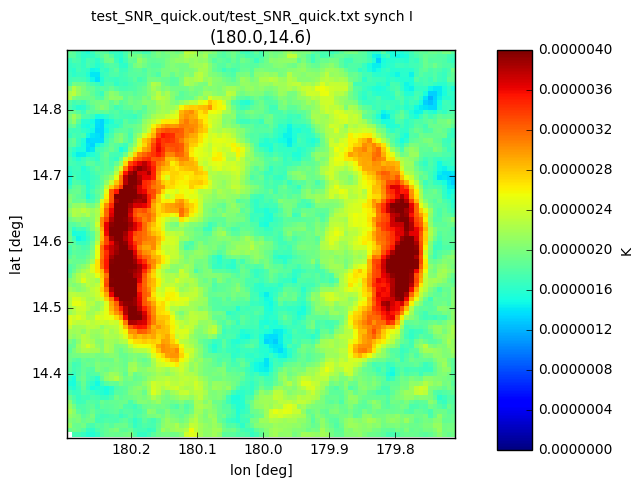

In [18]:
matplotlib.rcParams['figure.figsize'] = (7.0, 5.0)
data=view_patch(infile='test_SNR_quick.out/test_SNR_quick.txt',
           nside=8192,
           synch=True,
           min=0,
           max=4e-6
    )

Now let's change that scale and the index:

In [19]:
ham.call(custom_parameters={
    "B_field_do_random":"T",
    "B_field_cutoff":"0.002", # Cutoff now 5pc
    "B_field_alpha":"-3.7"  # Kolmogorov -5/3 (1D) is -11/3 in 3D (subtract 2)
})

.....

0

In [24]:
ham.print_log(-27,-23)

----------------------

DEBUGGING:  given the nx, lx, and cutoff you specified, you have:
DEBUGGING:     k_cutoff=10.5 and k0=42


We see the k_cutoff is now 10, which means the largest-scales (relative to the box size, ie. the smallest k) random fluctuations are being omitted.  You can now see this in the result, which shows only small-scale fluctuations.  The spectrum is also steeper, which means it is more dominated by that outer scale than it was before (though this is hard to see).

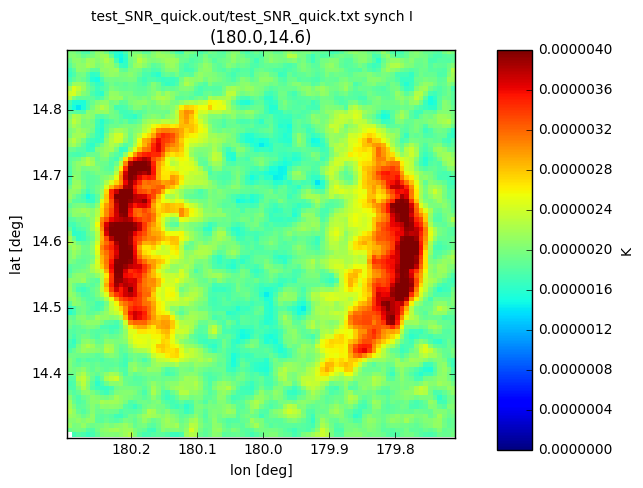

In [25]:
matplotlib.rcParams['figure.figsize'] = (7.0, 5.0)
data=view_patch(infile='test_SNR_quick.out/test_SNR_quick.txt',
           nside=8192,
           synch=True,
           min=0,
           max=4e-6
          )

# Numeric versus analytic treatment of random components

Now let's get into some of the stranger aspects of the integration.  First, you should read the document on the wiki that discusses the subtleties of how to run in numerical (default) or analytic mode:

https://sourceforge.net/p/hammurabicode/wiki/subtleties/

Once you've read that, here are some examples.

First, the most basic model:  a simple axi-symmetric spiral with an isotropic Gaussian random field:

...

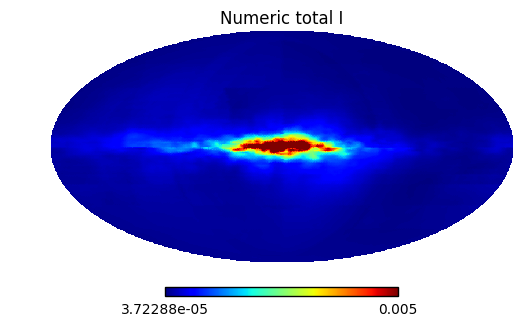

In [26]:
ham.cleanup()
ham=hampy.Hampy(custom_parameters={"B_field_do_random":"T"})
ham.call()
mapsN=ham.get_observables()
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
hp.mollview(mapsN['Is'],max=0.005,title='Numeric total I',hold=True,cmap=cmap)

As discussed in Jansson & Farrar (2012), the assumption of isotropy in the random component means that we can avoid computing the random component explicitly and simply compute the *average* amount of emission one would see from such a field.  See Eq. 1 from Jansson & Farrar (2012, ApJL, 761, L11) and the text above it.  In this case, the integrator adds sqrt(2/3) of the random amplitude to the regular field when computing the synchrotron emission (total and polarized) but does not add that component when computing the RM.  The above model computed analytically then looks like this:

In [27]:
ham=hampy.Hampy(custom_parameters={"B_field_do_random":"T",
                                   "use_B_analytic":"T"})
ham.call()
ham.get_params()

...

{'B_field_do_random': 'T',
 'B_field_nx': 128,
 'B_field_ny': 128,
 'B_field_nz': 26,
 'B_field_seed': '1486647502',
 'B_field_type': '1',
 'B_ran_mem_lim': '4',
 'TE_grid_filename': 'test/negrid_n400.bin',
 'TE_nx': '400',
 'TE_ny': '400',
 'TE_nz': '80',
 'do_dm': 'F',
 'do_dust': 'F',
 'do_ff': 'F',
 'do_rm': 'T',
 'do_sync_emission': 'T',
 'do_tau': 'F',
 'max_radius': '30',
 'obs_DM_file_name': '/Users/tjaffe/space/sw/hammurabi/sourceforge/hammurabicode-code/hampy/test.out/dm.fits',
 'obs_NSIDE': '128',
 'obs_RM_file_name': '/Users/tjaffe/space/sw/hammurabi/sourceforge/hammurabicode-code/hampy/test.out/rm.fits',
 'obs_dust_file_name': '/Users/tjaffe/space/sw/hammurabi/sourceforge/hammurabicode-code/hampy/test.out/IQU_dust.fits',
 'obs_ff_file_name': '/Users/tjaffe/space/sw/hammurabi/sourceforge/hammurabicode-code/hampy/test.out/free.fits',
 'obs_file_name': '/Users/tjaffe/space/sw/hammurabi/sourceforge/hammurabicode-code/hampy/test.out/IQU_sync.fits',
 'obs_freq_GHz': '23',
 'obs_

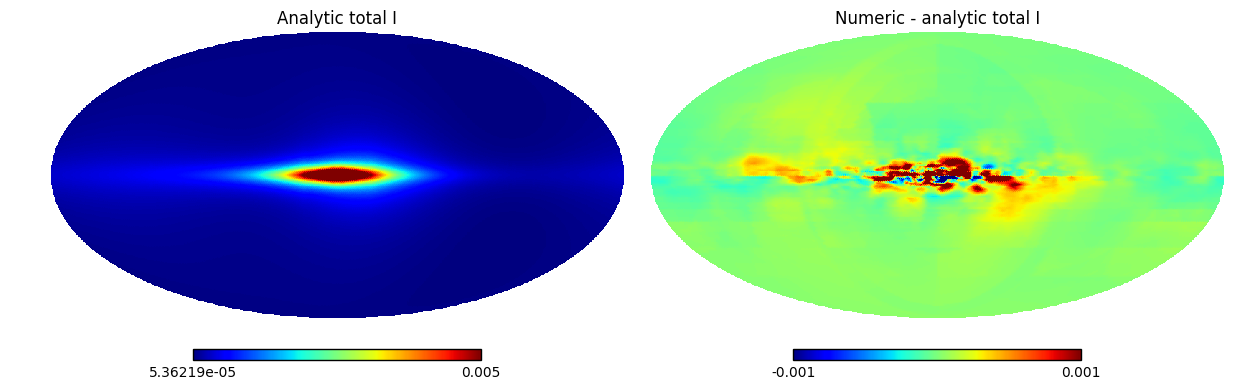

In [28]:
mapsA=ham.get_observables()
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
hp.mollview(mapsA['Is'],max=0.005,title='Analytic total I',sub=(1,2,1),cmap=cmap)
hp.mollview(mapsN['Is']-mapsA['Is'],min=-0.001,max=0.001, \
            title='Numeric - analytic total I',sub=(1,2,2),cmap=cmap)

The left plot above shows the average amount of emission.  In other words, if you had run an ensemble of numerically computed realizations of the random component and averaged the synchrotron emission, you would get this.  It represents the ensemble average of the result. The right shows the difference between a single numeric realization and that average

Any model implemented in hammurabi can be run both ways, since this applies to the random component, which is  computed numerically from a Gaussian random field (GRF) and added to the different coherent field models.  There are a couple of models, however, that do specify a random field specifically:  the JF12 and the Jaffe et al. (2010,2011,2013).  In these cases, the specific models specify what the average strength of the isotropic random component should be at each point in the Galaxy, and hammurabi scales the GRF appropriately in the numerical case.  In the analytic case, both models also work, as it computes the appropriate ensemble average emission for each location using the specified model.  

Note that what you lose computing analytically this way is the ability to understand the *variance* in the observables.  I'm unaware of a way to compute that analytically (except for the trivial cases laid out in Burn 1966 for example).  

The JF12 model in particular was originally coded this way.  But the default in hammurabi is to perform the integration numerically, i.e. it takes the JF12 model for the average field strength at a given position in the Galaxy and scales the numeric realization of the GRF appropriately to compute a numeric realization of the model. But you can go back to the originally way the JF12 model was used by setting use_B_analytic=T.  

# The Jansson & Farrar (2012) model
You can run the original JF12 model by selecting B_field_type=7.  But there are several other parameters that must be considered.  Since, as discussed on 
https://sourceforge.net/p/hammurabicode/wiki/subtleties/ , 
the parameter B_analytic_beta that controls the striated component is now a generic parameter (i.e., it can be added to any model) and is by default turned off, to get the original JF12 model, this needs to be turned back on.  Secondly, by default, the code uses the numerically computed Gaussian random field to create a realization of the random component.  If you want the original JF12 model as it was computed analytically, you need to set this.  Specifically:

In [29]:
ham.cleanup()
ham=hampy.Hampy(custom_parameters={
 "B_field_type":"7",       #  Select the JF12 model
 "B_field_do_random":"T",  #  Do include the random component
 "use_B_analytic":"T",     #  Use the analytic integration method 
 "B_analytic_beta":"1.36", #  Include the fudge factor corresponding to the striated field
 "B_field_RMS_uG":0.2      #  The default is 6uG, but for this model, this param scales up 
                           #   or down the JF12 random component. 1=original is a very strong random
                           #   component.  Here, we turn it down so the comparison is easier.
 })
ham.call()

....

0

/Users/Shared/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/healpy/projaxes.py:808: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  result[np.isinf(val.data)] = -np.inf


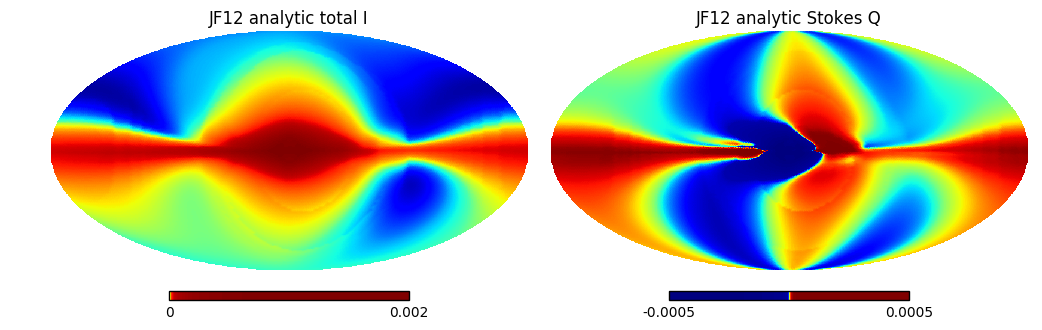

In [30]:
mapsJF=ham.get_observables()
matplotlib.rcParams['figure.figsize'] = (10.0, 4.0)
hp.mollview(mapsJF['Is'],min=0,max=2e-3,\
            title='JF12 analytic total I',norm='hist',sub=(1,2,1),cmap=cmap)
hp.mollview(mapsJF['Qs'],min=-5e-4,max=5e-4,\
            title='JF12 analytic Stokes Q',norm='hist',sub=(1,2,2),cmap=cmap)

Alternatively, do the same model numerically:

In [31]:
ham.cleanup()
ham=hampy.Hampy(custom_parameters={
  "B_field_type":"7",        #  Select the JF12 model
  "B_field_do_random":"T",   #  Do include the random component
  "use_B_analytic":"F",      #  Use the analytic integration method
  "B_analytic_beta":"1.36",  #  Include the fudge factor corresponding to the striated field
  "B_field_RMS_uG":0.2       #  The default is 6uG, but for this model, this param scales up 
                             #   or down the JF12 random component. 1=original is a very strong random
                             #   component.  Here, we turn it down so the comparison is easier.
   })
ham.call()


....

0

Here we plot on the left the numerically computed Stokes Q and on the right, the numerically minus the analytically computed.  

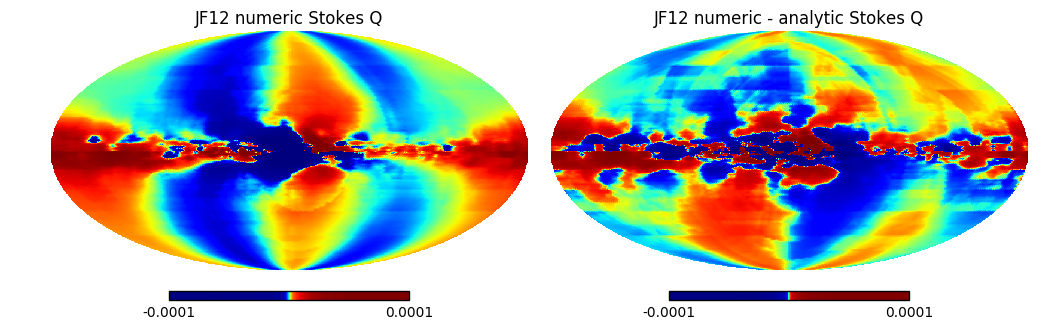

In [32]:
mapsJFN=ham.get_observables()
matplotlib.rcParams['figure.figsize'] = (10.0, 4.0)
hp.mollview(mapsJFN['Qs'],min=-1e-4,max=1e-4,\
            title='JF12 numeric Stokes Q',norm='hist',sub=(1,2,1),cmap=cmap)
hp.mollview(mapsJFN['Qs']-mapsJF['Qs'],min=-1e-4,\
            max=1e-4,title='JF12 numeric - analytic Stokes Q',\
            norm='hist',sub=(1,2,2),cmap=cmap)

To compute the RM for the original analytic JF12 model, we leave off the beta fudge. In this analytic case, the random component is irrelevant for the RM. (Hammurabi is smart enough that in the analytic case, it knows to use the 2/3 fudge factor for the isotropic random field only for the synchrotron (or dust) emission, not the RM.  But the beta factor is implemented differently, and hammurabi's not currently smart enough to do the RM correctly for non-zero beta.  I'm trying to avoid undue complexity, i.e. fragility.)

In [33]:
ham=hampy.Hampy(custom_parameters={
        "B_field_type":"7",         #  Select the JF12 model
        "use_B_analytic":"T",       #  Use the analytic integration method
        "do_synch_emission":"F",
        "do_rm":"T"
         })
ham.call()

...

0

/Users/Shared/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/healpy/pixelfunc.py:270: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


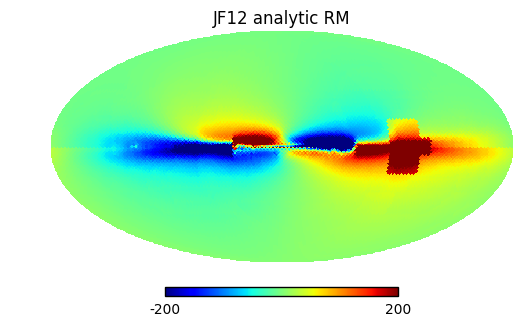

In [34]:
mapsJFRM=ham.get_observables()
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
hp.mollview(mapsJFRM['RM'],min=-200,max=200,title='JF12 analytic RM',hold=True,cmap=cmap)

Or we can compute it numerically to see the variance:

In [35]:
ham=hampy.Hampy(custom_parameters={
  "B_field_type":"7",         #  Select the JF12 model
  "do_synch_emission":"F",
  "do_rm":"T",
  "B_field_do_random":"T",   #  Do include the random component
  "use_B_analytic":"F",      #  Use the analytic integration method
  "B_field_RMS_uG":0.2       #  The default is 6uG, but for this model, this param scales up 
                             #   or down the JF12 random component. 1=original is a very strong random
                             #   component.  Here, we turn it down so the comparison is easier.
   })
ham.call()

....

0

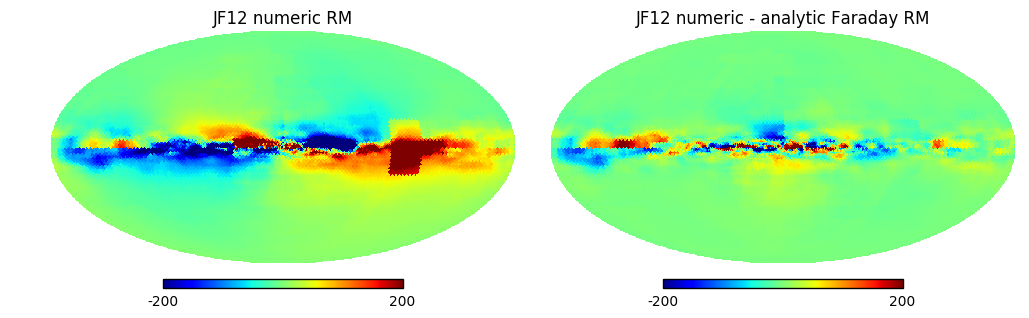

In [36]:
mapsJFRMN=ham.get_observables()
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
hp.mollview(mapsJFRMN['RM'],min=-200,max=200,\
            title='JF12 numeric RM',cmap=cmap,sub=(2,2,1))
hp.mollview(mapsJFRMN['RM']-mapsJFRM['RM'],min=-200,\
            max=200,title='JF12 numeric - analytic Faraday RM',\
            sub=(2,2,2),cmap=cmap)

# The Jaffe13 model
The model I've been using in papers Jaffe et al. (2010, 2011, and 2013) are implemented as field number 10.  This is another spiral arm model, though instead of discrete (and discontinuous) arm segments like the JF12, this model continuously adds four arms with Gaussian profiles to an exponential disk.  Before JF12 coined the term "striated field", the Jaffe13 model included a component we called the "ordered random" or "anisotropic random" component.  (For contributing to the terminology confusion, I apologize!)  But these two models implement this component very differently, both in physical and in practical ways.

Firstly, the JF12 "striated" field is simply applied as a fudge factor (B_analytic_beta discussed above) that increases the coherent component of the field by this factor.  It is therefore always an "analytic" component, even if you chose to compute the isotropic random component with a GRF realization.  

The numerically computed Jaffe13 "anisotropic random" component, by contrast, is generated directly from the GRF;  that component is projected onto the coherent field direction and scaled according to the B_f_ord parameter.  See Jaffe et al. (2010).  As in the case of B_analytic_beta, the B_f_ord parameter is a generic parameter that can be applied to any of the chosen field models, though it originated in the work of Jaffe et al. 2010.  

This means the anisotropic component does in fact change direction stochastically in the numerical case, and it does contribute correctly to the variance of the observables.  If you choose to compute analytically, then it will be fudged like JF12 with the difference that its strength scales with that of the random component instead of the coherent component.

This model has evolved slightly since the 2013 publication, but you can now run exactly the model from the Planck PIP XLII paper.  See 

https://sourceforge.net/projects/hammurabicode/files/supplementary/planck_pfiles/

specifically the discussion in the README.  The Planck paper's version of the Jaffe13 parameter file is included in the hampy test data, and we will use it rather than set them all here.  

In [41]:
#  Start with the full Galaxy, full resolution Planck parameters
ham=hampy.Hampy(custom_parameters="test/jaffe13b_Rg2_30.txt")
#  Note in particular that it has f_ord set:
ham.get_params(["B_f_ord"])

{'B_f_ord': '0.5'}

In [42]:
#  But for speed, let's run at much lower resolution:
ham.call(custom_parameters={
    "min_radius":0,
    "total_shell_numb":3,
    "vec_size_R":100,
    "B_field_nx":128,
    "B_field_ny":128,
    "B_field_nz":16,
    "B_field_cutoff":1,
    "Cfield_type":1     #  Just use exponential disk, not the Galprop from PIPXLII
})

...

0

Since it is computed numerically rather than through a fudge, this run produces the correct IQU for synchrotron as well as the correct RM.  

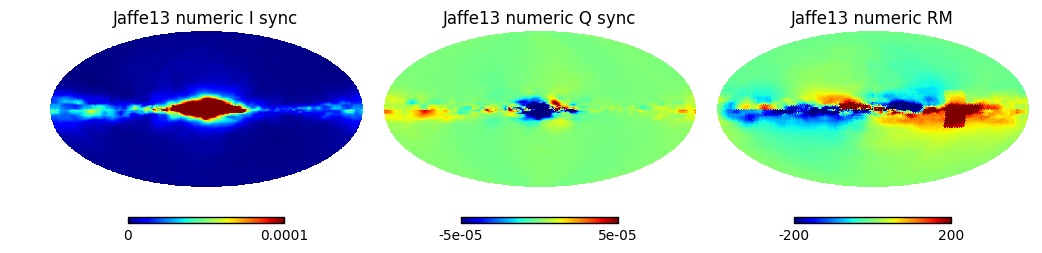

In [43]:
mapsJ13=ham.get_observables()
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
hp.mollview(mapsJ13['Is'],min=0,max=1e-4,\
            title='Jaffe13 numeric I sync',cmap=cmap,sub=(1,3,1))
hp.mollview(mapsJ13['Qs'],min=-5e-5,max=5e-5,\
            title='Jaffe13 numeric Q sync',cmap=cmap,sub=(1,3,2))
hp.mollview(mapsJ13['RM'],min=-200,max=200,\
            title='Jaffe13 numeric RM',cmap=cmap,sub=(1,3,3))


#  Using emission templates
For both dust and synchrotron emission, hammurabi computes the full Stokes parameters, I, Q, and U, though only in the case of synchrotron is the emissivity physically modeled from the CRE density and the magnetic field strength.  For dust, it is effectively a unitless  emissivity that is integrated for the total intensity.  And for synchrotron, the CRE density models are very simple and not well constrained for the relevant low-energy leptons.  

For these reasons, it may be desirable to make use of total intensity sky maps.  For either observable, a total intensity template can be given to hammurabi.  In this case, the code will integrate through the simulated Galaxy as before and compute the Stokes I, Q, and U maps.  But at the end, the Stokes I will be replaced by the given template, T, and the Stokes Q and U will be replaced with TQ/I and TU/I, i.e. the template multiplied by the "pure model" polarization.  

Note that currently, this template renormalization is hard wired to assume the synchrotron template is at 408MHz, and it will only work for the case of CRE field types 1, 2, 3, or 8 (which all use a power law spectral index) and will fail for other types.  Let me know if you need this to be made more flexible;  it's not hard to change, but I don't use this myself, so I haven't bothered.

For dust emission, there is a "dust_template_frequency" parameter as well as a "dust_spec_index".  

Let's redo the above example of analytically computed synchrotron emission, but this time, we'll use the Haslam map as a total intensity template:

In [44]:
ham=hampy.Hampy(custom_parameters={
        "B_field_do_random":"T",
        "use_B_analytic":"T",
        "do_sync_renorm":"T",   #  Flag to renormalize.  
        "sync_template_fname":"../unit_test/inputs/map_I_408MHz_K.fits",  # Template file.
        })
ham.call()
#ham.get_params()

...

0

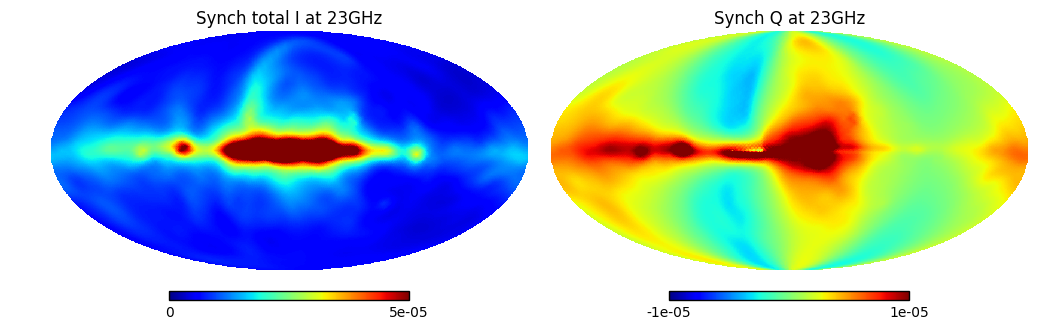

In [45]:
mapsT=ham.get_observables()
matplotlib.rcParams['figure.figsize'] = (10.0, 4.0)
hp.mollview(mapsT['Is'],min=0,max=5e-5,\
            title='Synch total I at 23GHz',cmap=cmap,sub=(1,2,1))
hp.mollview(mapsT['Qs'],min=-1e-5,\
            max=1e-5,title='Synch Q at 23GHz',\
            sub=(1,2,2),cmap=cmap)
